## Imports

In [5]:
import itertools
import math
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from prettytable import PrettyTable

from pprint import *

## Initial Observations

In [4]:
adidas = pd.read_csv("data/adidas_merged_cleaned.csv", index_col = 0)

print("Basic information about our Adidas' footwear dataset:\n")
print(adidas.info())
print(adidas.describe())
display(adidas.head(3))

Basic information about our Adidas' footwear dataset:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2390 entries, 0 to 2389
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          2389 non-null   object 
 1   subtitle       2360 non-null   object 
 2   num_colors     2390 non-null   object 
 3   url            2390 non-null   object 
 4   price          2386 non-null   object 
 5   reduced_price  2246 non-null   object 
 6   description    2368 non-null   object 
 7   details        2248 non-null   object 
 8   colors         1945 non-null   object 
 9   n_reviews      2180 non-null   float64
 10  avg_stars      2180 non-null   float64
 11  product_code   2390 non-null   object 
dtypes: float64(2), object(10)
memory usage: 242.7+ KB
None
          n_reviews    avg_stars
count   2180.000000  2180.000000
mean     841.304128     4.578578
std     2402.486479     0.361305
min        1.000000     1.0000

,title,subtitle,num_colors,url,price,reduced_price,description,details,colors,n_reviews,avg_stars,product_code
0,Start Your Run Shoes,Women's Running,4 colors,/us/start-your-run-shoes/GY9233.html,$65,$33,You'll want these adidas running shoes the nex...,Regular fit; Lace closure; Textile upper; LIGH...,Dash Grey / Matte Silver / Core Black,5.0,4.8,GY9233
1,NMD_R1 Shoes,Youth Originals,1,/us/nmd_r1-shoes/H03994.html,$130,$91,"One shoe to rule them all. School, work or kic...",Regular fit; Lace closure; Mesh upper; Boost m...,NaN,131.0,4.6,H03994
2,Edge Lux Shoes,Women's Training,5 colors,/us/edge-lux-shoes/GZ6741.html,$90,$45,"Comfort is key, whether you're racing to catch...",Women's-specific fit; Lace closure; Textile up...,Core Black / Core Black / Iron Metallic,191.0,4.0,GZ6741


## Grouping categories in subtitle

In [7]:
pprint(list(adidas['subtitle'].unique()))

["Women's Running",
 'Youth Originals',
 "Women's Training",
 'Sportswear',
 "Men's Sportswear",
 "Men's Essentials",
 "Women's Sportswear",
 "Women's Originals",
 "Women's • Essentials",
 "Women's • Originals",
 "Women's • Running",
 "Women's • Sportswear",
 "Men's • Essentials",
 'Originals',
 "Men's • Running",
 "Men's • Originals",
 'Kids Unisex • Originals',
 'Running',
 'Kids Unisex • Sportswear',
 'Yoga',
 'Essentials',
 "Men's • Sportswear",
 'Kids Unisex • Essentials',
 'Children Essentials',
 "Men's • TERREX",
 "Women's TERREX",
 'Basketball',
 "Men's Soccer",
 'Swim',
 "Men's TERREX",
 "Women's Essentials",
 "Men's Running",
 'Infant & Toddler Training',
 'Kids Unisex • TERREX',
 "Women's • Basketball",
 "Women's • Training",
 "Men's • Five Ten",
 'Kids Unisex • Lifestyle',
 "Women's • Swim",
 "Women's • adidas by Stella McCartney",
 'Cycling',
 "Men's • Soccer",
 "Women's • TERREX",
 'Soccer',
 "Men's Originals",
 'Children Sportswear',
 'Kids Essentials',
 'Infant & Toddle

In [8]:
adidas = adidas.replace({'subtitle' : { 'Shoe' : "Men's Shoe", "Men's Shoes" : "Men's Shoe"}})
adidas = adidas.replace({'subtitle' : { ".+Running.+" : "Running Shoe"}}, regex = True)
adidas = adidas.replace({'subtitle' : { ".+Basketball.+" : "Basketball Shoe"}}, regex = True)
adidas = adidas.replace({'subtitle' : { "Basketball.+" : "Basketball Shoe"}}, regex = True)
adidas = adidas.replace({'subtitle' : { ".+Baseball.+" : "Baseball Shoe"}}, regex = True)
adidas = adidas.replace({'subtitle' : { "Baseball.+" : "Baseball Shoe"}}, regex = True)
adidas = adidas.replace({'subtitle' : { ".+Hiking.+" : "Hiking Shoe"}}, regex = True)
adidas = adidas.replace({'subtitle' : { "HIIT.+" : "Training Shoe"}}, regex = True)
adidas = adidas.replace({'subtitle' : { ".+Skate.+" : "Skate Shoe"}}, regex = True)
adidas = adidas.replace({'subtitle' : { ".+Football.+" : "Football Shoe"}}, regex = True)
adidas = adidas.replace({'subtitle' : { "Football.+" : "Football Shoe"}}, regex = True)
adidas = adidas.replace({'subtitle' : { ".+Slide.+" : "Sandal"}}, regex = True)
adidas = adidas.replace({'subtitle' : { "Slide" : "Sandal"}}, regex = True)
adidas = adidas.replace({'subtitle' : { ".+Boot.+" : "Boot"}}, regex = True)
adidas = adidas.replace({'subtitle' : { ".+Boot$" : "Boot"}}, regex = True)
adidas = adidas.replace({'subtitle' : { ".+Lacrosse.+" : "Lacrosse Shoe"}}, regex = True)
adidas = adidas.replace({'subtitle' : { "Lacrosse.+" : "Lacrosse Shoe"}}, regex = True)
adidas = adidas.replace({'subtitle' : { ".+Lifestyle.+" : "Lifestyle Shoe"}}, regex = True)
adidas = adidas.replace({'subtitle' : { ".+Cycling.+" : "Cycling Shoe"}}, regex = True)
adidas = adidas.replace({'subtitle' : { ".+Thong.+" : "Sandal"}}, regex = True)
adidas = adidas.replace({'subtitle' : { "Thong" : "Sandal"}}, regex = True)
adidas = adidas.replace({'subtitle' : { ".+Flip Flop.+" : "Sandal"}}, regex = True)
adidas = adidas.replace({'subtitle' : { "Flip Flop" : "Sandal"}}, regex = True)
adidas = adidas.replace({'subtitle' : { "Flip-Flop" : "Sandal"}}, regex = True)
adidas = adidas.replace({'subtitle' : { ".+Sandal.+" : "Sandal"}}, regex = True)
adidas = adidas.replace({'subtitle' : { ".+Sandal" : "Sandal"}}, regex = True)
adidas = adidas.replace({'subtitle' : { ".+Slide" : "Sandal"}}, regex = True)
adidas = adidas.replace({'subtitle' : { "Slip$" : "Sandal"}}, regex = True) 
adidas = adidas.replace({'subtitle' : { "^Slip-On$" : "Sandal"}}, regex = True)
adidas = adidas.replace({'subtitle' : { ".+Softball.+" : "Softball Shoe"}}, regex = True)
adidas = adidas.replace({'subtitle' : { "Softball.+" : "Softball Shoe"}}, regex = True)                
adidas = adidas.replace({'subtitle' : { ".+Golf.+" : "Golf Shoe"}}, regex = True)
adidas = adidas.replace({'subtitle' : { "Golf.+" : "Golf Shoe"}}, regex = True)
adidas = adidas.replace({'subtitle' : { ".+Soccer.+" : "Soccer Shoe"}}, regex = True)
adidas = adidas.replace({'subtitle' : { ".+Tennis.+" : "Tennis Shoe"}}, regex = True)
adidas = adidas.replace({'subtitle' : { ".+Training.+" : "Training Shoe"}}, regex = True)
adidas = adidas.replace({'subtitle' : { "Custom.+" : "Custom Shoe"}}, regex = True)
adidas = adidas.replace({'subtitle' : { "High Top" : "Lifestyle Shoe"}}, regex = True)
adidas = adidas.replace({'subtitle' : { "Lifestyle Shoe \(Extra Wide\)" : "Lifestyle Shoe"}}, regex = True)
adidas = adidas.replace({'subtitle' : { "Print Slide" : "Printed Slide"}}, regex = True)
adidas = adidas.replace({'subtitle' : { "Racing.+" : "Racing Shoe"}}, regex = True)
adidas = adidas.replace({'subtitle' : { "Unisex Racing Shoe" : "Racing Shoe"}}, regex = True)
adidas = adidas.replace({'subtitle' : { ".+Track.+" : "Track Shoe"}}, regex = True)
adidas = adidas.replace({'subtitle' : { "^Track Spike$" : "Track Shoe"}}, regex = True)
adidas = adidas.replace({'subtitle' : { "Unisex Shoe" : "Lifestyle Shoe"}}, regex = True)
adidas['subtitle'] = adidas['subtitle'].str.replace("Men's","")
adidas['subtitle'] = adidas['subtitle'].str.replace("Women's","")
adidas['subtitle'] = adidas['subtitle'].str.replace("• ","")
adidas['subtitle'] = adidas['subtitle'].str.strip()
adidas = adidas.replace({'subtitle' : { "^Shoe" : "Lifestyle Shoe"}}, regex = True)
adidas = adidas.replace({'subtitle' : { "Children.+" : "Children Shoe"}}, regex=True)
adidas = adidas.replace({'subtitle' : { "Kids.+" : "Children Shoe"}}, regex=True)
adidas = adidas.replace({'subtitle' : { "Girls.+" : "Children Shoe"}}, regex=True)
adidas = adidas.replace({'subtitle' : { "Boys.+" : "Children Shoe"}}, regex=True)
adidas = adidas.replace({'subtitle' : { "Infant & Toddler.+" : "Children Shoe"}}, regex=True)
adidas = adidas.replace({'subtitle' : { "Youth.+" : "Children Shoe"}}, regex=True)

In [11]:
unique_subtitle = list(adidas['subtitle'].unique())

print(f"There are {len(unique_subtitle)} unique subtitles/categories")
pprint(unique_subtitle)

There are 25 unique subtitles/categories
['Running',
 'Children Shoe',
 'Training',
 'Sportswear',
 'Essentials',
 'Originals',
 'Yoga',
 'TERREX',
 'Basketball',
 'Soccer',
 'Swim',
 'Five Ten',
 'adidas by Stella McCartney',
 'Cycling',
 'Golf',
 nan,
 'Tennis',
 'Y-3',
 'Volleyball',
 'Football',
 'Weightlifting',
 'Track & Field',
 'Baseball',
 'Boxing',
 'Softball']


In [12]:
display(adidas.head(3))

,title,subtitle,num_colors,url,price,reduced_price,description,details,colors,n_reviews,avg_stars,product_code
0,Start Your Run Shoes,Running,4 colors,/us/start-your-run-shoes/GY9233.html,$65,$33,You'll want these adidas running shoes the nex...,Regular fit; Lace closure; Textile upper; LIGH...,Dash Grey / Matte Silver / Core Black,5.0,4.8,GY9233
1,NMD_R1 Shoes,Children Shoe,1,/us/nmd_r1-shoes/H03994.html,$130,$91,"One shoe to rule them all. School, work or kic...",Regular fit; Lace closure; Mesh upper; Boost m...,NaN,131.0,4.6,H03994
2,Edge Lux Shoes,Training,5 colors,/us/edge-lux-shoes/GZ6741.html,$90,$45,"Comfort is key, whether you're racing to catch...",Women's-specific fit; Lace closure; Textile up...,Core Black / Core Black / Iron Metallic,191.0,4.0,GZ6741


## Plot Numeric Variables

In [13]:
# remove $ and convert price to float
adidas['price'] = adidas['price'].str.replace("$",'').str.replace(',','').astype(np.float64)

/var/folders/kl/zzq83xsx65s2p501hz1mwvlw0000gn/T/ipykernel_4040/3618100312.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  adidas['price'] = adidas['price'].str.replace("$",'').str.replace(',','').astype(np.float64)


In [14]:
adidas['num_colors'] = adidas['num_colors'].str.extract('(\d+)').astype(np.float64)

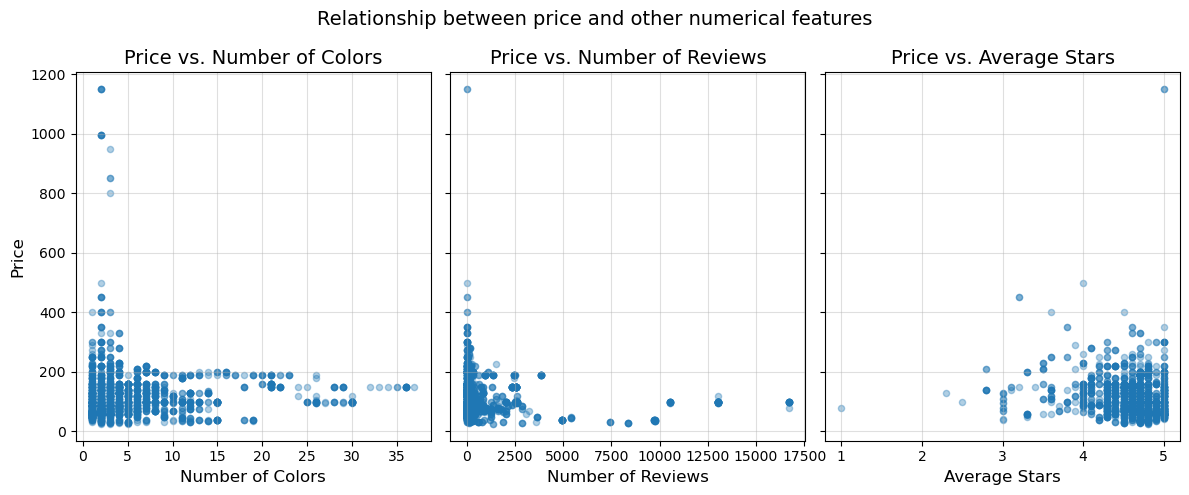

In [23]:
fig, axes = plt.subplots(1, 3, sharey = True, figsize = (12, 5))

fontsize = 14

cols = ["num_colors", "n_reviews", "avg_stars"] 
title_vs_text = ["num_colors", "n_reviews", "avg_stars"]
xlabels = ["Number of Colors", "Number of Reviews", "Average Stars"]

for i, (ax, col, title_vs, xlabel) in enumerate(
            zip(axes, cols, title_vs_text, xlabels) ):

    ax.scatter(adidas[col], adidas["price"], alpha = 0.35, s = 20)
    ax.set_title(f"Price vs. {xlabel}", fontsize = fontsize)
    ax.set_xlabel(xlabel, fontsize = fontsize-2)
    ax.set_ylabel("Price" if i == 0 else None, 
        fontsize = fontsize - 2)
    ax.grid(":", alpha=0.4)

plt.suptitle("Relationship between price and other numerical features", 
             fontsize = fontsize)
plt.tight_layout()

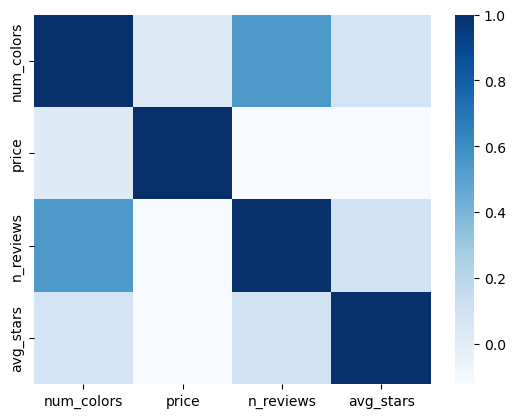

In [24]:
cor = adidas.corr()
sns.heatmap(cor, cmap = 'Blues')
plt.show()

## Plot Categorical Variables

In [12]:
top_subtitles = adidas.subtitle.value_counts().head()
top_subtitles

Originals        635
Children Shoe    565
Running          265
Sportswear       151
Essentials       136
Name: subtitle, dtype: int64

In [13]:
adidas_top_subtitles = adidas.loc[adidas.subtitle.isin(top_subtitles.index.tolist())]

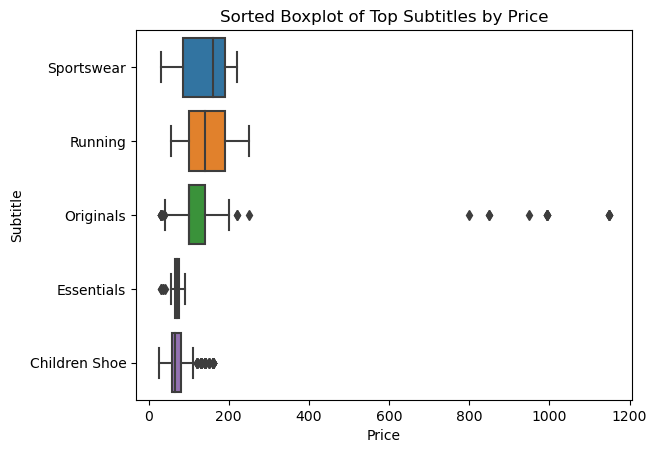

In [14]:
top_subtitles_sorted = adidas_top_subtitles.groupby('subtitle').price.median().sort_values(ascending=False)

# order box plot by median
sns.boxplot(data=adidas_top_subtitles, y='subtitle', x='price', order=top_subtitles_sorted.index)
plt.xlabel('Price')
plt.ylabel('Subtitle')
plt.title('Sorted Boxplot of Top Subtitles by Price')
plt.show()

## Numeric Stats

In [15]:
mean_price = adidas["price"].mean() 
mean_noc = adidas["num_colors"].mean()
std_price = adidas["price"].std() 
std_noc = adidas["num_colors"].std()
print(
    "\n"
    f"The mean price is {mean_price:.4f} \n"
    f"The mean number of colors is {mean_noc:.4f} \n"
    f"The Standard Deviation of price is {std_price:.4f}\n"
    f"The Standard Deviation of number of colors is {std_noc:.4f}"
)


The mean price is 119.7339 
The mean number of colors is 5.6943 
The Standard Deviation of price is 87.6957
The Standard Deviation of number of colors is 6.2613


In [16]:
price_min = adidas["price"].min()
price_max = adidas["price"].max() 
price_range = price_max - price_min 

print(
    f"The range of price for which shoes in our dataset "
    f"is {price_range:,.2f} dolloars. \n\n"
    f"The maximum number of price is {price_max:,.2f}, "
    f"and the minimum is {price_min:,.2f}."
)

The range of price for which shoes in our dataset is 1,125.00 dolloars. 

The maximum number of price is 1,150.00, and the minimum is 25.00.


/var/folders/df/y6mck5f93m5_f04v7_qhxmp40000gn/T/ipykernel_58166/1773199538.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(adidas['price'], color='orange')


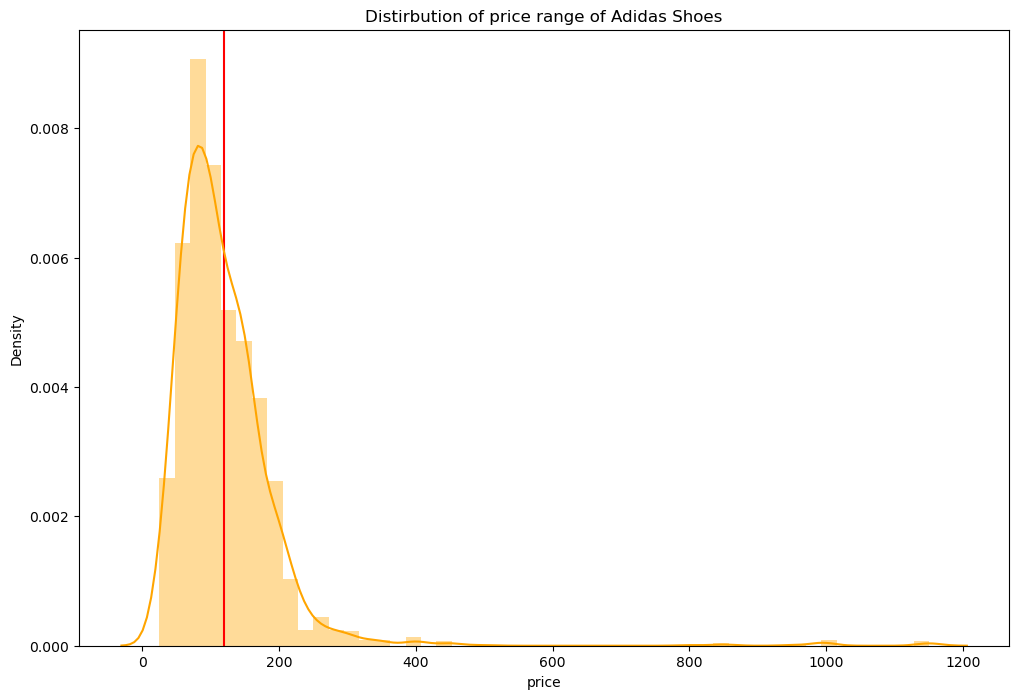

In [17]:
plt.figure(figsize=(12,8))
#ploting the mean
plt.axvline(mean_price, 0, 1, color = 'red')
sns.distplot(adidas['price'], color='orange')
plt.title("Distirbution of price range of Adidas Shoes")
plt.show()

## Missing Data

In [18]:
n_rows_with_missingness = np.int64(sum([True for idx,row in adidas.iterrows() if any(row.isnull())]))
n_cols_with_missingness = np.int64(sum(adidas.apply(lambda x: sum(x.isnull().values), axis = 0)>0))

columns = adidas.columns.values
col_num = []
for i in columns:
    col_num.append(adidas[i].isnull().sum())
col_missingness = pd.Series(col_num, index=adidas.columns)
col_missingness

Unnamed: 0         0
title              1
subtitle          30
num_colors        28
url                0
price              4
reduced_price    144
description       22
details          142
colors           445
n_reviews        210
avg_stars        210
product_code       0
dtype: int64

In [19]:
# Replaced Missing Values with Median For Now
median_price = adidas['price'].median()
adidas['price'].fillna(median_price, inplace=True)

In [20]:
# nike_train, y_train = nike_train.drop(columns=['price']), nike_train['price']
# nike_test, y_test = nike_test.drop(columns=['price']), nike_test['price']

In [21]:
# nike_train, y_train = nike_train.drop(columns=['reduced_price']), nike_train['reduced_price']
# nike_test, y_test = nike_test.drop(columns=['reduced_price']), nike_test['reduced_price']

In [22]:
# columns = nike_train.columns.values
# print(f'There are {len(columns)} in the Nike_train Data Frame:')
# for i in columns:
    # print(f'  The {i} column is missing {nike_train[i].isnull().sum()} values')

# MSE & R2 

In [23]:
mse_list = []
r2_list = []
# List of all predictor combinations to fit the curve
cols = [['num_colors'],['n_reviews'],['avg_stars'],['num_colors','n_reviews'],['avg_stars','n_reviews'],['num_colors','avg_stars'],['num_colors','n_reviews','avg_stars']]
adidas['num_colors'].fillna(adidas['num_colors'].median(), inplace=True)
adidas['n_reviews'].fillna(adidas['n_reviews'].median(), inplace=True)
adidas['avg_stars'].fillna(adidas['avg_stars'].median(), inplace=True)

In [25]:
# Loop over all the predictor combinations 
for i in cols:
    # Replaced Missing Values with Median For Now
    
    print(i)
    # Set each of the predictors from the previous list as x
    x = adidas[i]
    # Set the "Sales" column as the reponse variable
    y = adidas['price']
   
    # Split the data into train-test sets with 80% training data and 20% testing data. 
    # Set random_state as 0
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=.8,random_state=0)

    # Initialize a Linear Regression model
    lreg = LinearRegression()

    # Fit the linear model on the train data
    lreg.fit(x_train,y_train)
    
    # Predict the response variable for the test set using the trained model
    y_pred= lreg.predict(x_test)
    
    # Compute the MSE for the test data
    MSE = mean_squared_error(y_pred,y_test)
    r2 = r2_score(y_test, y_pred)
    
    # Append the computed MSE to the list
    mse_list.append(MSE)
    r2_list.append(r2)

['num_colors']
['n_reviews']
['avg_stars']
['num_colors', 'n_reviews']
['avg_stars', 'n_reviews']
['num_colors', 'avg_stars']
['num_colors', 'n_reviews', 'avg_stars']


In [26]:
# Helper code to display the MSE for each predictor combination
t = PrettyTable(['Predictors', 'MSE'])
p = PrettyTable(['Predictors', 'R2 score'])

for i in range(len(mse_list)):
    t.add_row([cols[i],round(mse_list[i], 2)])
    p.add_row([cols[i],round(r2_list[i], 2)])
    

print(t)
print(p)

+------------------------------------------+---------+
|                Predictors                |   MSE   |
+------------------------------------------+---------+
|              ['num_colors']              | 8629.75 |
|              ['n_reviews']               | 8555.15 |
|              ['avg_stars']               | 8703.21 |
|       ['num_colors', 'n_reviews']        |  8481.9 |
|        ['avg_stars', 'n_reviews']        |  8621.9 |
|       ['num_colors', 'avg_stars']        | 8701.53 |
| ['num_colors', 'n_reviews', 'avg_stars'] | 8552.71 |
+------------------------------------------+---------+
+------------------------------------------+----------+
|                Predictors                | R2 score |
+------------------------------------------+----------+
|              ['num_colors']              |   -0.0   |
|              ['n_reviews']               |   0.01   |
|              ['avg_stars']               |  -0.01   |
|       ['num_colors', 'n_reviews']        |   0.02   |
|  

# Sentiment Analysis

In [27]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/tomzhang/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [28]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

In [29]:
# copy new df to work on
df = adidas.loc[:, ['subtitle','description', 'price']].copy()
df.dropna(inplace=True)

In [30]:
analyzer = SIA()
# using sentiment analysis and get negative, neutral, poisitve scores on columns "rating"
df['rating'] = df['description'].apply(analyzer.polarity_scores)
df

,subtitle,description,price,rating
0,Running,You'll want these adidas running shoes the nex...,65.0,"{'neg': 0.032, 'neu': 0.842, 'pos': 0.126, 'co..."
1,Children Shoe,"One shoe to rule them all. School, work or kic...",130.0,"{'neg': 0.0, 'neu': 0.854, 'pos': 0.146, 'comp..."
2,Training,"Comfort is key, whether you're racing to catch...",90.0,"{'neg': 0.035, 'neu': 0.854, 'pos': 0.111, 'co..."
3,Sportswear,Classics for a reason. These adidas slides are...,40.0,"{'neg': 0.0, 'neu': 0.777, 'pos': 0.223, 'comp..."
4,Sportswear,It doesn't really matter whether or not a run ...,85.0,"{'neg': 0.028, 'neu': 0.903, 'pos': 0.068, 'co..."
...,...,...,...,...
2385,Children Shoe,We all fall in love with the beautiful game on...,70.0,"{'neg': 0.054, 'neu': 0.798, 'pos': 0.148, 'co..."
2386,Children Shoe,Good players create time and space. Great ones...,130.0,"{'neg': 0.033, 'neu': 0.699, 'pos': 0.268, 'co..."
2387,Children Shoe,Swerve ordinary to find your edge. Introduce a...,65.0,"{'neg': 0.0, 'neu': 0.963, 'pos': 0.037, 'comp..."
2388,Sportswear,The world's top runners enter the Berlin Marat...,180.0,"{'neg': 0.033, 'neu': 0.902, 'pos': 0.065, 'co..."


In [31]:
# change each keys/values of dictionary in colum, rating, to be the new columns of dataframe
df2 = pd.concat([df.drop(['rating'], axis=1), df['rating'].apply(pd.Series)], axis=1)
df2

,subtitle,description,price,neg,neu,pos,compound
0,Running,You'll want these adidas running shoes the nex...,65.0,0.032,0.842,0.126,0.7430
1,Children Shoe,"One shoe to rule them all. School, work or kic...",130.0,0.000,0.854,0.146,0.8126
2,Training,"Comfort is key, whether you're racing to catch...",90.0,0.035,0.854,0.111,0.6124
3,Sportswear,Classics for a reason. These adidas slides are...,40.0,0.000,0.777,0.223,0.9413
4,Sportswear,It doesn't really matter whether or not a run ...,85.0,0.028,0.903,0.068,0.4232
...,...,...,...,...,...,...,...
2385,Children Shoe,We all fall in love with the beautiful game on...,70.0,0.054,0.798,0.148,0.9287
2386,Children Shoe,Good players create time and space. Great ones...,130.0,0.033,0.699,0.268,0.9810
2387,Children Shoe,Swerve ordinary to find your edge. Introduce a...,65.0,0.000,0.963,0.037,0.2960
2388,Sportswear,The world's top runners enter the Berlin Marat...,180.0,0.033,0.902,0.065,0.2732


In [32]:
df2['score'] = np.where(df2['compound'] < 0, 'negative', 'positive')
df2

,subtitle,description,price,neg,neu,pos,compound,score
0,Running,You'll want these adidas running shoes the nex...,65.0,0.032,0.842,0.126,0.7430,positive
1,Children Shoe,"One shoe to rule them all. School, work or kic...",130.0,0.000,0.854,0.146,0.8126,positive
2,Training,"Comfort is key, whether you're racing to catch...",90.0,0.035,0.854,0.111,0.6124,positive
3,Sportswear,Classics for a reason. These adidas slides are...,40.0,0.000,0.777,0.223,0.9413,positive
4,Sportswear,It doesn't really matter whether or not a run ...,85.0,0.028,0.903,0.068,0.4232,positive
...,...,...,...,...,...,...,...,...
2385,Children Shoe,We all fall in love with the beautiful game on...,70.0,0.054,0.798,0.148,0.9287,positive
2386,Children Shoe,Good players create time and space. Great ones...,130.0,0.033,0.699,0.268,0.9810,positive
2387,Children Shoe,Swerve ordinary to find your edge. Introduce a...,65.0,0.000,0.963,0.037,0.2960,positive
2388,Sportswear,The world's top runners enter the Berlin Marat...,180.0,0.033,0.902,0.065,0.2732,positive


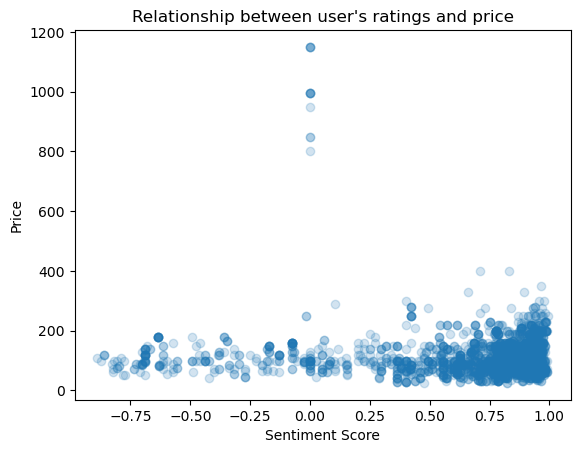

In [33]:
plt.scatter(df2['compound'], df2["price"], alpha=0.2)
plt.xlabel("Sentiment Score")
plt.ylabel("Price")
plt.title("Relationship between user's ratings and price")
plt.show()

In [34]:
X = df2[['compound']]
y = df2['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=True, random_state=109)

In [35]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1754, 1), (585, 1), (1754,), (585,))

In [36]:
lreg = LinearRegression().fit(X_train, y_train)

y_pred = lreg.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

print("MSE is {:.4f}; R score is {:.4f}".format(MSE,r2))

MSE is 6092.9034; R score is 0.0031


# Just for the nagative score description

In [37]:
positive_des = (df2['score']=='positive').sum()
negative_des = (df2['score']=='negative').sum()
print(f"There are {positive_des} positive descritions and {negative_des} negative descriptions.")

There are 2124 positive descritions and 215 negative descriptions.


In [38]:
neg = df2[df2['score']=='negative']
neg

,subtitle,description,price,neg,neu,pos,compound,score
9,Essentials,These adidas sneakers are tasteful and minimal...,60.0,0.110,0.829,0.061,-0.4902,negative
21,Originals,Timeless appeal. Effortless style. Everyday ve...,95.0,0.048,0.905,0.047,-0.0258,negative
31,Originals,"When worlds collide, magic happens. These adid...",70.0,0.036,0.964,0.000,-0.0772,negative
37,Originals,Millions of people have laced into adidas Stan...,100.0,0.103,0.851,0.047,-0.8176,negative
47,Originals,"Remember the epic shots, close games and fierc...",110.0,0.036,0.934,0.031,-0.0772,negative
...,...,...,...,...,...,...,...,...
2294,Originals,"Statement makers and risk takers, these adidas...",100.0,0.148,0.734,0.118,-0.0562,negative
2301,Children Shoe,"When you step onto the pitch, don't just play ...",50.0,0.115,0.860,0.025,-0.7805,negative
2317,Children Shoe,Throw it back to '70s Southern California skat...,65.0,0.065,0.905,0.031,-0.2023,negative
2325,Basketball,Strike when your opponent least expects it. Dr...,150.0,0.118,0.789,0.092,-0.1697,negative


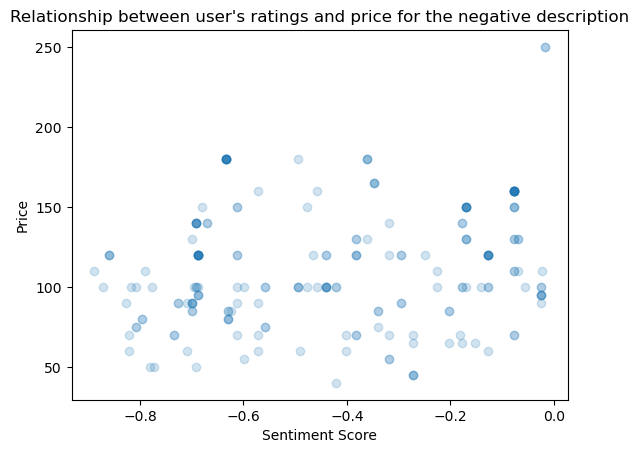

In [39]:
plt.scatter(neg['compound'], neg["price"], alpha=0.2)
plt.xlabel("Sentiment Score")
plt.ylabel("Price")
plt.title("Relationship between user's ratings and price for the negative description")
plt.show()

In [40]:
X_n = neg[['compound']]
y_n = neg['price']
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_n, y_n, train_size=0.75, shuffle=True, random_state=109)

In [41]:
X_train_n.shape, X_test_n.shape, y_train_n.shape, y_test_n.shape

((161, 1), (54, 1), (161,), (54,))

In [42]:
# Fitting Linear Regression 
lreg = LinearRegression()
linreg = lreg.fit(X_train_n,y_train_n)
# Compute the MSE of the model
y_hat_train_n = lreg.predict(X_train_n)
lin_train_mse_n = mean_squared_error(y_train_n, y_hat_train_n)

y_hat_test_n = lreg.predict(X_test_n)
lin_test_mse_n = mean_squared_error(y_test_n, y_hat_test_n)

# Compute the R-squared of the model
r2_n = r2_score(y_test_n, y_hat_test_n)

In [43]:
print("Train MSE is {:.4f} and Test MSE is {:.4f}".format(lin_train_mse_n,lin_test_mse_n,))
print(f"Test R-squared is {r2_n:.4f}")

Train MSE is 1272.0770 and Test MSE is 1537.0136
Test R-squared is 0.0265


In [44]:
degree, train_mses_mean, val_mses_mean, val_mses_std = [],[],[],[]
max_deg = 30

for i in range(1, max_deg+1):    
    degree.append(i)
    x_poly_train = PolynomialFeatures(degree = i).fit_transform(X_train)
    lreg = LinearRegression(fit_intercept=False)
    cross = cross_validate(lreg, x_poly_train, y_train, cv=10, scoring="neg_mean_squared_error", return_train_score=True)
    avg_val_score = -np.mean(cross['test_score'])
    avg_train_score = -np.mean(cross['train_score'])
    train_mses_mean.append(avg_train_score)
    val_mses_mean.append(avg_val_score)   
    val_mses_std.append(np.std(cross['test_score']))

In [45]:
print("The lowest polynomial degree for the validation error is " + str(np.argmin(val_mses_mean)+1))
print("The train MSE value corresponding to this degree is " + str(train_mses_mean[np.argmin(val_mses_mean)]))
print("The validation MSE value corresponding to this degree is " + str(val_mses_mean[np.argmin(val_mses_mean)]))

The lowest polynomial degree for the validation error is 25
The train MSE value corresponding to this degree is 6380.641300065863
The validation MSE value corresponding to this degree is 6637.273113703511


In [46]:
neg_og = neg[neg['subtitle']=='Originals']

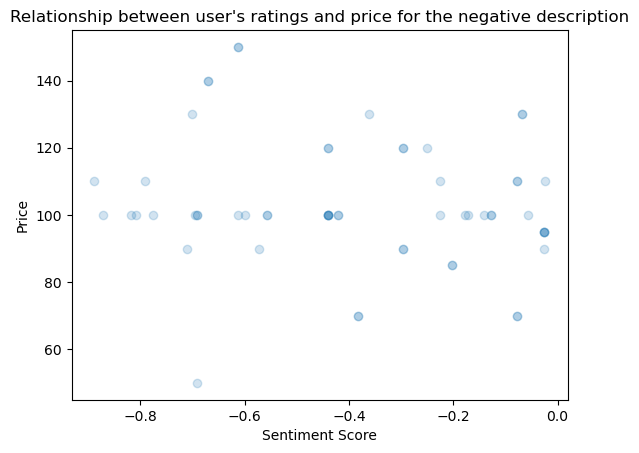

In [47]:
plt.scatter(neg_og['compound'], neg_og["price"], alpha=0.2)
plt.xlabel("Sentiment Score")
plt.ylabel("Price")
plt.title("Relationship between user's ratings and price for the negative description")
plt.show()

In [48]:
X_og = neg[['compound']]
y_og = neg['price']
X_train_og, X_test_og, y_train_og, y_test_og = train_test_split(X_og, y_og, train_size=0.75, shuffle=True, random_state=109)

In [49]:
# Fitting Linear Regression 
lreg = LinearRegression()
linreg = lreg.fit(X_train_og,y_train_og)
# Compute the MSE of the model
y_hat_train_og = lreg.predict(X_train_og)
lin_train_mse_og = mean_squared_error(y_train_og, y_hat_train_og)

y_hat_test_og = lreg.predict(X_test_og)
lin_test_mse_og = mean_squared_error(y_test_og, y_hat_test_og)

# Compute the R-squared of the model
r2_og = r2_score(y_test_og, y_hat_test_og)

print("Train MSE is {:.4f} and Test MSE is {:.4f}".format(lin_train_mse_og,lin_test_mse_og,))
print(f"Test R-squared is {r2_og:.4f}")

Train MSE is 1272.0770 and Test MSE is 1537.0136
Test R-squared is 0.0265


### Okay, no more numeric comparison

# NLP Section

In [50]:
df_desc = adidas.loc[:, ['description', 'price']].copy()  # subset
df_desc.dropna(inplace=True)  # drop na
df_desc.head()

,description,price
0,You'll want these adidas running shoes the nex...,65.0
1,"One shoe to rule them all. School, work or kic...",130.0
2,"Comfort is key, whether you're racing to catch...",90.0
3,Classics for a reason. These adidas slides are...,40.0
4,It doesn't really matter whether or not a run ...,85.0


In [51]:
# Following Tom's Nike NLP section codes
df_desc['description'] = df_desc['description'].str.lower()
df_desc['description'] = df_desc['description'].str.replace(r'([^\w\s]|_)+', '', regex=True)
df_desc['description'] = df_desc['description'].str.split()
stopwords = pd.read_csv('data/stopwords_nopunc.csv').stopwords.values
df_desc['description'] = df_desc['description'].apply(lambda x: [str(w) for w in x if w not in stopwords])
vocab_counts = df_desc['description'].explode().value_counts()
min_count = 5
vocab = [k for k,v in vocab_counts.items() if v >= 5]
print(f"We have {len(vocab):,} unique word in our reduced, corpus vocabulary.")

We have 2,412 unique word in our reduced, corpus vocabulary.


In [52]:
# vectorization methods
df_desc['description'] = df_desc['description'].apply(lambda x: [w for w in x if w in vocab])
counts = df_desc['description'].apply(Counter).to_list()
bow_df = pd.DataFrame(counts).fillna(0).astype(int)
bow_df

,want,adidas,running,shoes,next,time,step,route,classic,lines,...,lightningquick,sprintskin,relieving,orketro,empty,hellcat,extension,innings,cleated,agile
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2363,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2364,0,2,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2365,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2366,0,1,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
# bin price into 5 brackets - make sure to achieve class balance

In [54]:
df_desc.reset_index(drop=True, inplace=True)
df_processed = pd.concat([bow_df, df_desc['price']], axis=1)

In [55]:
# check default percentile cut
pd.cut(df_processed.price, bins=5).value_counts()

(23.875, 250.0]    2306
(250.0, 475.0]       48
(925.0, 1150.0]      10
(700.0, 925.0]        3
(475.0, 700.0]        1
Name: price, dtype: int64

In [56]:
# make everything > 200 its only bin
df_processed['is_above_200'] = df_processed.price > 200
df_processed['bracket'] = df_processed.price > 200
df_processed['bracket'].replace(True, 'above_200', inplace=True)
df_processed['bracket'].replace(False, np.nan, inplace=True)

In [57]:
# use default binning for <= 200
binned_low_brackets = pd.cut(df_processed.loc[~df_processed['is_above_200'], 'price'], bins=4)

In [58]:
# combine the bins
df_processed['bracket'] = df_processed['bracket'].fillna(binned_low_brackets)
df_processed['price'] = df_processed['bracket'].astype('string')

In [59]:
# clean up
df_processed.drop(['is_above_200', 'bracket'], axis=1, inplace=True)

In [60]:
df_processed.head()

,want,adidas,running,shoes,next,time,step,route,classic,lines,...,sprintskin,relieving,orketro,empty,hellcat,extension,innings,cleated,agile,price
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,"(24.825, 68.75]"
1,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"(112.5, 156.25]"
2,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"(68.75, 112.5]"
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"(24.825, 68.75]"
4,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"(68.75, 112.5]"


# Naive Bayes

In [61]:
X_train, X_test, y_train, y_test = train_test_split(df_processed.drop('price', axis=1),
                                                    df_processed['price'], test_size=0.2, random_state=109)

In [62]:
mnb = MultinomialNB().fit(X_train, y_train)
mnb.score(X_test, y_test)

0.729957805907173

***Feature importance for each class:***

In [63]:
# 5 brackets
y_train.value_counts(sort=False)

(68.75, 112.5]     695
(112.5, 156.25]    419
(24.825, 68.75]    378
(156.25, 200.0]    279
above_200          123
Name: price, dtype: Int64

In [64]:
# get most predictive words for each class (bracket 1 and bracket 3)
feat_imp_list = []

for i in range(len(mnb.classes_)):
    class_prob_sorted = mnb.feature_log_prob_[i, :].argsort()[::-1]
    top_pred_words = np.take(bow_df.columns, class_prob_sorted[:])
    feat_imp_list.append(top_pred_words)

The top 10 most predictive words for each price bracket:

In [65]:
# prettify list to df
feat_imp_df = pd.DataFrame(np.array(feat_imp_list).T, columns=mnb.classes_)
feat_imp_df = feat_imp_df.loc[:, y_train.value_counts(sort=False).index]  # reorder columns
feat_imp_df.head(10)

,"(68.75, 112.5]","(112.5, 156.25]","(24.825, 68.75]","(156.25, 200.0]",above_200
0,adidas,shoes,recycled,shoes,adidas
1,recycled,adidas,adidas,adidas,shoes
2,shoes,upper,upper,upper,upper
3,upper,waste,shoes,plastic,outsole
4,made,made,made,50,running
5,content,recycled,content,made,y3
6,waste,content,waste,recycled,midsole
7,50,boost,one,boost,primeknit
8,materials,plastic,50,ocean,made
9,help,midsole,materials,energy,run


# Linear Support Vector Machine

In [66]:
sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)

In [67]:
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
accuracy

0.8544303797468354

# Logistic Regression

In [68]:
# TODO: need to find other ways
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy_log = accuracy_score(y_pred, y_test)
accuracy_log

/Users/tomzhang/_DS/harvard/AC209a/git/harvard_109_shoes/conda-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8713080168776371

# Random Forest

In [69]:
from sklearn.ensemble import RandomForestClassifier

In [70]:
rf = RandomForestClassifier(n_estimators=1000, random_state=0).fit(X_train, y_train)
random_forest_train_score = rf.score(X_train, y_train)
random_forest_test_score = rf.score(X_test, y_test)

In [71]:
print(f"random forest test score is {random_forest_test_score}")

random forest test score is 0.8713080168776371


In [72]:
top_predictors_rf = df_processed.columns[[dtree.tree_.feature[0] for dtree in rf.estimators_]]
top_predictors_rf = pd.Series(top_predictors_rf).value_counts().sort_values(ascending = False)
top_predictors_rf = pd.DataFrame(top_predictors_rf, columns = ['Count'])
print("Top Predictor Counts - Random Forest")
display(top_predictors_rf)

Top Predictor Counts - Random Forest


,Count
energy,24
ultraboost,24
parley,24
primeknit,23
slides,21
...,...
environmental,1
one,1
ultra,1
strides,1


# TFIDF

Term frequency (TF) = (Number of Occurrences of a word)/(Total words in the document)

***Want to calculate each word's TF-IDF score relative to each of the 5 price brackets.***

In [73]:
df_docs = df_processed.groupby('price').sum()
df_docs

,want,adidas,running,shoes,next,time,step,route,classic,lines,...,lightningquick,sprintskin,relieving,orketro,empty,hellcat,extension,innings,cleated,agile
price,,,,,,,,,,,,,,,,,,,,,
"(112.5, 156.25]",20,544,139,580,36,57,92,0,42,14,...,5,0,0,4,5,1,0,3,3,0
"(156.25, 200.0]",24,387,150,377,29,70,92,2,39,3,...,0,0,0,2,0,4,0,0,0,10
"(24.825, 68.75]",10,454,85,340,4,41,56,4,76,5,...,0,0,0,0,0,0,0,5,0,0
"(68.75, 112.5]",19,863,161,790,22,62,150,1,136,19,...,0,13,7,0,0,0,6,0,2,0
above_200,3,161,71,134,9,15,34,0,3,0,...,0,0,0,0,0,0,0,0,0,0


***Transform BOW representation into list of documents:***

In [74]:
docs = []  # documents - a list of strings (unique words concatenated for each bracket)

for bracket in df_docs.index:
    row = df_docs.loc[bracket, :]
    # logic: replace nonzero with NA; fill NA with column names; remove unfilled values (counts)
    row[row != 0] = np.nan
    doc = row.astype('string').fillna(row.index.to_series())
    doc = doc.loc[~doc.str.match('.+\..+')].tolist()
    doc = ' '.join(doc)
    docs.append(doc)

docs[4]  # concatenated unique words for last price bracket

'want adidas running shoes next time step classic combine style every athlete trainers designed around way move featuring support cushioning elevated road track made series recycled materials upper features least 50 content product represents one solutions help end plastic waste shoe keep look thanks sleek triple design everyday technology sneakers energyreturning boost beneath feet comfort whether racing miles weekend midsole thats light flexible moving collar locks stride reason perfect versatility fit snugly slip easily iconic pair ready matter run day feel give edge hit pavement got whatever feeling long going lightweight soft super stylish big graphics laces slipon textile covered easy freedom comfortable feature print extra energy go first onto basketball take make proportions legend theyve smooth leather 3stripes heel tab theyre finished rubber toe get canvas feels comfy details like good part impact virgin clean heritage stay primegreen highperformance city version knit crafted

***TF-IDF of each word relative to each price bracket***

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = docs
vectorizer = TfidfVectorizer(use_idf=True)
tfIdf = vectorizer.fit_transform(corpus)
df_tfidf = pd.DataFrame(tfIdf.T.todense(), index=vectorizer.get_feature_names_out(), columns=df_docs.index)

df_tfidf

price,"(112.5, 156.25]","(156.25, 200.0]","(24.825, 68.75]","(68.75, 112.5]",above_200
10,0.000000,0.030066,0.000000,0.022779,0.037630
10k,0.020519,0.025293,0.000000,0.019162,0.031656
11,0.000000,0.044895,0.000000,0.000000,0.000000
12,0.000000,0.036221,0.000000,0.027441,0.000000
14067,0.029385,0.000000,0.000000,0.027441,0.000000
...,...,...,...,...,...
young,0.024392,0.000000,0.028891,0.022779,0.000000
zip,0.000000,0.000000,0.000000,0.027441,0.045333
zone,0.017355,0.021392,0.020556,0.016207,0.026774
zones,0.020519,0.025293,0.000000,0.019162,0.031656


***TF-IDF should give us some idea of words that are truly unique to each bracket:***

In [76]:
# check out first bracket's words with highest TF-IDF
df_tfidf.iloc[:, 0].sort_values(ascending=False).head(10)

responds        0.036422
dlx             0.036422
sunset          0.036422
postup          0.036422
sunrise         0.036422
rounds          0.036422
diecut          0.036422
positionless    0.036422
consistency     0.036422
hyperturf       0.036422
Name: (112.5, 156.25], dtype: float64

In [77]:
# check out first bracket's words with lowest TF-IDF
df_tfidf.iloc[:, 0].sort_values(ascending=True).head(10)

10                 0.0
lengthmeasuring    0.0
lens               0.0
lesson             0.0
letting            0.0
lieins             0.0
lift               0.0
lightning          0.0
limit              0.0
list               0.0
Name: (112.5, 156.25], dtype: float64

## Prep Data for Advanced Modeling

### Non text features

In [78]:
# drop NA based on col description
df = adidas.dropna(subset='description').copy()
df.head(1)

,Unnamed: 0,title,subtitle,num_colors,url,price,reduced_price,description,details,colors,n_reviews,avg_stars,product_code
0,0,Start Your Run Shoes,Running,4.0,/us/start-your-run-shoes/GY9233.html,65.0,$33,You'll want these adidas running shoes the nex...,Regular fit; Lace closure; Textile upper; LIGH...,Dash Grey / Matte Silver / Core Black,5.0,4.8,GY9233


In [79]:
# subtitle categorical feature
subtitle_freq = df.subtitle.value_counts()
subtitle_freq

Originals                     633
Children Shoe                 563
Running                       265
Sportswear                    148
Essentials                    132
TERREX                         92
Soccer                         72
Five Ten                       68
Golf                           58
Basketball                     54
Baseball                       42
Swim                           39
Training                       36
adidas by Stella McCartney     32
Tennis                         27
Football                       26
Cycling                        14
Yoga                           12
Weightlifting                   8
Volleyball                      6
Y-3                             5
Track & Field                   5
Boxing                          1
Softball                        1
Name: subtitle, dtype: int64

In [80]:
# clean subtitle up - counts < 30, make them into an 'other' category
df.loc[df.subtitle.isin(subtitle_freq[subtitle_freq < 30].index), 'subtitle'] = 'other'

In [81]:
df.subtitle.value_counts()

Originals                     633
Children Shoe                 563
Running                       265
Sportswear                    148
Essentials                    132
other                         105
TERREX                         92
Soccer                         72
Five Ten                       68
Golf                           58
Basketball                     54
Baseball                       42
Swim                           39
Training                       36
adidas by Stella McCartney     32
Name: subtitle, dtype: int64

In [82]:
# rename it
df.rename({'subtitle': 'category'}, axis=1, inplace=True)

### Other non text features

In [83]:
# subset
df_sub = df.loc[:, ['num_colors', 'n_reviews', 'avg_stars', 'category']].copy()
df_sub.head(3)

,num_colors,n_reviews,avg_stars,category
0,4.0,5.0,4.8,Running
1,1.0,131.0,4.6,Children Shoe
2,5.0,191.0,4.0,Training


In [84]:
# dummy
df_sub = pd.get_dummies(df_sub)
df_sub.head(3)

,num_colors,n_reviews,avg_stars,category_Baseball,category_Basketball,category_Children Shoe,category_Essentials,category_Five Ten,category_Golf,category_Originals,category_Running,category_Soccer,category_Sportswear,category_Swim,category_TERREX,category_Training,category_adidas by Stella McCartney,category_other
0,4.0,5.0,4.8,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,1.0,131.0,4.6,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,5.0,191.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [85]:
# prefix all non-text features - to distinguish from BOW words
df_sub.columns = ['feature_' + col for col in df_sub.columns]
df_sub.head(3)

,feature_num_colors,feature_n_reviews,feature_avg_stars,feature_category_Baseball,feature_category_Basketball,feature_category_Children Shoe,feature_category_Essentials,feature_category_Five Ten,feature_category_Golf,feature_category_Originals,feature_category_Running,feature_category_Soccer,feature_category_Sportswear,feature_category_Swim,feature_category_TERREX,feature_category_Training,feature_category_adidas by Stella McCartney,feature_category_other
0,4.0,5.0,4.8,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,1.0,131.0,4.6,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,5.0,191.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### Concatenate with BOW

In [86]:
df_sub.reset_index(drop=True, inplace=True)

In [87]:
df_model = pd.concat([df_processed[['price']], df_sub, df_processed.drop('price', axis=1)], axis=1)

In [88]:
df_model.rename({'price': 'target_price'}, axis=1, inplace=True)

In [89]:
df_model.head()

,target_price,feature_num_colors,feature_n_reviews,feature_avg_stars,feature_category_Baseball,feature_category_Basketball,feature_category_Children Shoe,feature_category_Essentials,feature_category_Five Ten,feature_category_Golf,...,lightningquick,sprintskin,relieving,orketro,empty,hellcat,extension,innings,cleated,agile
0,"(24.825, 68.75]",4.0,5.0,4.8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"(112.5, 156.25]",1.0,131.0,4.6,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"(68.75, 112.5]",5.0,191.0,4.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"(24.825, 68.75]",19.0,9735.0,4.7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"(68.75, 112.5]",3.0,866.0,4.6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Note the structure:

- target: `target_price`
- non-text features: `feature_xxx` - 3 numeric, 1 categorical (dummified category)
- text features from description: put at the end of the df

### Save final df for further modeling

In [91]:
df_model.to_csv('data/adidas_model.csv', index=False)